# 🎟️ Proyecto de Análisis de Marketing y Comportamiento de Usuarios en Showz
📊 Resumen del proyecto
Este análisis de datos se centra en el comportamiento de los usuarios y el rendimiento del marketing de Showz, una plataforma de venta de entradas para eventos. El objetivo es ofrecer recomendaciones prácticas para optimizar el presupuesto de marketing y mejorar las estrategias de adquisición de clientes.

🧩 El proyecto incluye:

🧠 Análisis del comportamiento del usuario:
Frecuencia de uso, duración de sesiones y patrones de regreso al sitio.

💸 Análisis de ventas e ingresos:
Tiempos de conversión, tamaño promedio de compra y valor de vida del cliente (LTV).

📈 Evaluación del rendimiento de marketing:
Cálculo de costos totales, CAC (costo de adquisición) por canal y ROMI.

🧪 Análisis de cohortes:
Comparación del rendimiento por fuente de tráfico y tipo de dispositivo.

📊 Visualizaciones:
Gráficos que muestran tendencias de visitas, compras y efectividad de campañas.

🧾 Herramientas utilizadas:
Python, pandas, matplotlib, seaborn, Jupyter Notebook

📍Objetivo:
Brindar recomendaciones estratégicas basadas en datos sobre dónde invertir, cuánto y por qué, para maximizar los resultados del marketing.

## Paso 1: Carga y procesamiento de datos.



In [154]:
#Primero cargamos las librerías necesarias para el proyecto.
import pandas as pd #Pandas para la manipulación de datos
import numpy as np 
import scipy.stats as st #Numpy y Scipy para operaciones matemáticas y estadísticas.
import matplotlib.pyplot as plt
import seaborn as sns #Matplotlib y seaborn para visualizaciones.
import math

In [155]:
#Vamos a cargar los datos a continuación.
visits_df = pd.read_csv('../Data/visits_log_us.csv')
orders_df = pd.read_csv('../Data/orders_log_us.csv')
costs_df = pd.read_csv('../Data/costs_us.csv')

### Visits_df

In [156]:
#Ahora vamos a mostrar información general de los 3 datasets.
visits_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


El DataFrame visits_df contiene información sobre visitas a la página web, incluyendo el dispositivo mediante el cual se inicio la sesión, la fecha y hora de inicio y final de la sesión, la fuente de la cuál provino ese cliente y el identificador único del usuario. Se puede ver que no hay valores ausentes, lo cual es un buen indicativo, voy a convertir las columnas de fechas al tipo de datos correspondientes, las demás son correctas, de igual manera vamos a estandarizar los nombres de las columnas a snake_case.

In [157]:
#Primero estandarizamos los nombres de las columnas.
visits_df.columns = visits_df.columns.str.lower().str.replace(' ', '_')
visits_df.columns


Index(['device', 'end_ts', 'source_id', 'start_ts', 'uid'], dtype='object')

In [158]:
#Convertimos las columnas start_ts y end_ts a tipo datetime.
visits_df['start_ts'] = pd.to_datetime(visits_df['start_ts'])
visits_df['end_ts'] = pd.to_datetime(visits_df['end_ts'])
visits_df.dtypes

device               object
end_ts       datetime64[ns]
source_id             int64
start_ts     datetime64[ns]
uid                  uint64
dtype: object

In [159]:
#Vamos a buscar valores duplicados.
visits_df.duplicated().sum()

0

Ahora es tiempo de optimizar los datos, para análisis posteriores. Por el momento vamos a agregar las columnas para mes y día de la semana y otra columna para la duración de la sesión.

In [160]:
#Extraemos la fecha de la sesión
visits_df['session_date'] = visits_df['start_ts'].dt.date.astype('datetime64[ns]')
visits_df['session_year'] = visits_df['session_date'].dt.year
visits_df['session_month'] = visits_df['session_date'].dt.month
#Extraemos el número de la semana.
visits_df['session_week'] = visits_df['session_date'].dt.isocalendar().week

#Extraemos el día de la semana.
visits_df['session_dow'] = visits_df['session_date'].dt.day_of_week

#Calculamos la duración de la sesión en segundos.
visits_df['session_duration'] = visits_df['end_ts'] - visits_df['start_ts']
visits_df['session_duration'] = visits_df['session_duration'].dt.total_seconds()
visits_df.head()

,device,end_ts,source_id,start_ts,uid,session_date,session_year,session_month,session_week,session_dow,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017,12,51,2,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018,2,8,0,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017,7,26,5,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018,5,20,6,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017,12,52,2,0.0


### Orders_df

In [161]:
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


El DataFrame orders_df contiene información de compras, incluyendo la fecha y hora de compra, el ingreso, y el user ID, los registros están completos. Vamos a estandarizar los nombres de las columnas y a convertir la columna buy_ts a tipo Datetime.

In [162]:
#Estandarizamos el nombre de las columnas.
orders_df.columns = orders_df.columns.str.lower().str.replace(' ', '_')
orders_df.columns

Index(['buy_ts', 'revenue', 'uid'], dtype='object')

In [163]:
#Convertimos a tipo Datetime
orders_df['buy_ts'] = pd.to_datetime(orders_df['buy_ts'])
orders_df.dtypes

buy_ts     datetime64[ns]
revenue           float64
uid                uint64
dtype: object

In [164]:
#Vamos a buscar duplicados.
orders_df.duplicated().sum()

0

Para este dataframe vamos a realizar lo mismo que con el otro excepto por la duración de la sesión, para posteriormente poder analizar y calcular las distintas métricas.

In [165]:
orders_df['order_date'] = orders_df['buy_ts'].dt.date.astype('datetime64[ns]')
orders_df['order_year'] = orders_df['buy_ts'].dt.year
orders_df['order_month'] = orders_df['order_date'].dt.month
orders_df['order_dow'] = orders_df['order_date'].dt.day_of_week
orders_df.head()

,buy_ts,revenue,uid,order_date,order_year,order_month,order_dow
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017,6,3
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017,6,3
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017,6,3
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017,6,3
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017,6,3


### Costs_df

In [166]:
costs_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


El DataFrame costs_df contiene información sobre los gastos de Marketing, incluyendo la fuente en la que se invirtió(redes sociales, email, etc.), la fecha, y el total gastado en dicha fecha. Primero vamos a estandarizar el nombre de las columnas, después vamos a convertir a tipo datetime la columna dt, después vamos a verificar duplicados.

In [167]:
#Convertimos la columna a tipo Datetime
costs_df['dt'] = pd.to_datetime(costs_df['dt'])
costs_df.dtypes

source_id             int64
dt           datetime64[ns]
costs               float64
dtype: object

In [168]:
#Buscamos duplicados.
costs_df.duplicated().sum()

0

## Paso 2: Informes y métricas.

Para comenzar con nuestro análisis, calcularemos distintas métricas para dar respuesta a las siguientes preguntas con respecto a las visitas a la tienda de Showz:

* ¿Cuántas personas lo usan cada día, semana y mes?
* ¿Cuántas sesiones hay por día? (Un usuario puede tener más de una sesión).
* ¿Cuál es la duración de cada sesión?
* ¿Con qué frecuencia los usuarios regresan?





### Visitas

#### DAU (Daily active users)

In [169]:
#Primero vamos a calcular el número de usuarios que visitan la página al diariamente, esto es el DAU.
visits_dau = visits_df.groupby('session_date')['uid'].nunique().mean()
visits_dau


907.9917582417582

El número promedio de usuarios que visitan la tienda diariamente es de 907.99

#### WAU (Weekly active users)

In [170]:
#Ahora calculamos el número de usuarios activos a la semana, es decir el WAU.
visits_wau = visits_df.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
visits_wau

uid    5716.245283
dtype: float64

El número promedio de usuarios que visitan la tienda semanalmente es de 5716.

#### MAU (Monthly active users)

In [171]:
#Calculamos el número de usuarios activos mensualmente (MAU).
visits_mau = visits_df.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
visits_mau

uid    23228.416667
dtype: float64

El número promedio de usuarios que visitan la tienda mensualmente es de 23228.

#### Comparación 2017 vs 2028.
Las métricas que calculamos anteriormente no nos dicen mucho por si solas, necesitamos compararlas con algo para saber si bien, los usuarios aumentaron o incluso disminuyeron, por lo que voy a calcular unicamente el DAU pero segmentando los datos por año, para darnos una pequeña idea de la situación de la tienda.

In [172]:
#Filtramos los datos para el 2017
visits_2017 = visits_df.query('session_year == 2017')

#Filtramos los datos para el 2018
visits_2018 = visits_df.query('session_year == 2018')

#Calculamos el DAU para el 2017
dau_2017 = visits_2017.groupby('session_date')['uid'].nunique().mean()

#Calculamos el DAU para el 2018
dau_2018 = visits_2018.groupby('session_date')['uid'].nunique().mean()

print(f'''
    El número número promedio de usuarios activos diariamente en 2017 fue de: {dau_2017}, 
    mientras que en 2018 fue de: {dau_2018}
''')



    El número número promedio de usuarios activos diariamente en 2017 fue de: 845.2803738317757, 
    mientras que en 2018 fue de: 997.46



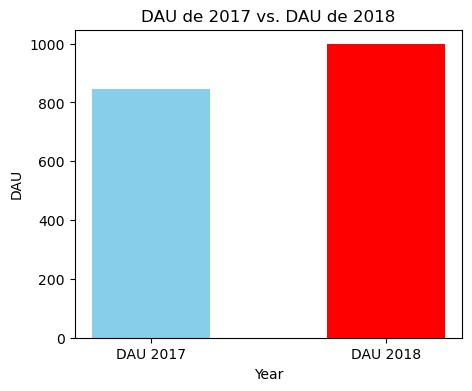

In [173]:
#Vamos a visualizar esta comparación.
labels = ['DAU 2017', 'DAU 2018']
dau_data = [dau_2017, dau_2018]

#Creamos el gráfico.
plt.figure(figsize=(5, 4))
plt.bar(labels, dau_data, color=['skyblue', 'red'], width=0.5)

#Le damos formato.
plt.title('DAU de 2017 vs. DAU de 2018')
plt.xlabel('Year')
plt.ylabel('DAU')

plt.show()



Como vemos en la parte posterior, el número de usuarios para el 2018 ha aumentado en comparación con el 2017, esta comparación puede resultar un poco ambigua, sin embargo nos da una idea de que la compañía de Showz ha crecido en cuanto al número de usuarios que visitan la tienda, además el objetivo de nuestro análisis no es comparar periodos.

#### Sesiones por día.

In [174]:
#Calculamos el número de sesiones diarias. 
sessions_per_day = visits_df.groupby('session_date')['uid'].count().mean()
sessions_per_day

987.3626373626373

El número de sesiones diarias supera por muy poco al número de usuarios activos diarios, esto quiere decir que muy pocos usuarios tienden a visitar la página más de una vez al día, lo cual tiene sentido, ya que no van a comprar muchos boletos a distintas horas del día.

#### ASL (Average session lenght)

In [175]:
# Ahora vamos a calcular la duración promedio de cada sesión, anteriormente agregamos la columna de duración, por lo que ahora 
# solo tenemos que calcular la media de tal columna.
visits_asl = visits_df['session_duration'].mean()
print('ASL en segundos:', visits_asl)

ASL en segundos: 643.0256872565387


La duración promedio de cada sesión es de 643 segundos, lo cual es bastante, son más de 10 minutos, sin embargo debido a la naturaleza de el producto/servicio que estamos analizando, no podemos concluir que el ASL es bueno, es probable que los usuarios se demoren al elegir sus entradas en los espectáculos.

#### Sticky Factor 

In [176]:
sticky_factor_mau = (visits_dau / visits_mau)*100
sticky_factor_mau

uid    3.90897
dtype: float64

In [177]:
sticky_factor_wau = (visits_dau / visits_wau)*100
sticky_factor_wau

uid    15.884409
dtype: float64

Nuestro "Sticky Factor" es bastante bajo, solo el 3.9% de los usuarios activos mensuales usan la plataforma todos los días, mientras que el 15.88% de los usuarios activos semanales están activos cada día. Nuevamente, reitero, debido a la naturaleza de el producto, este Sticky factor no es preocupante, ¿Por qué? porqué las personas no compran entradas para conciertos todos los días, por ende, no entran a la tienda tan a menudo como nos gustaría.

### Ventas

Para el DataFrame de orders, con respecto a las ventas que se realizaron en la tienda, vamos a dar respuesta a las siguientes preguntas: 

1. ¿Cuándo empieza la gente a comprar? 
2. ¿Cuántos pedidos hacen durante un período de tiempo dado?
3. ¿Cuál es el tamaño promedio de compra?
4. ¿Cuánto dinero traen? (LTV)

#### TTC (Time to conversion)

In [178]:
#Para calcular el tiempo que transcurre entre el registro y la primera compra de los clientes, primero vamos a encontrar su primera visita.
first_visit = visits_df.groupby('uid')['session_date'].min().reset_index()
first_visit.columns = ['uid', 'first_visit']

#Ahora debemos encontrar la primera compra de cada usuario.
first_order = orders_df.groupby('uid')['order_date'].min().reset_index()
first_order.columns = ['uid', 'first_order']

#Unimos ambos DataFrames.
visits_orders = first_visit.merge(first_order, on='uid')
visits_orders.head()


,uid,first_visit,first_order
0,313578113262317,2017-09-18,2018-01-03
1,1575281904278712,2017-06-03,2017-06-03
2,2429014661409475,2017-10-11,2017-10-11
3,2464366381792757,2018-01-27,2018-01-28
4,2551852515556206,2017-11-24,2017-11-24


In [179]:
#Calculamos el tiempo que transcurre desde el registro hasta la primera compra, en días.
visits_orders['time_to_conversion'] = (visits_orders['first_order'] - visits_orders['first_visit']).dt.days

#Obtenemos la media, esto es igual al TTC.
print('Time to conversion:', visits_orders['time_to_conversion'].mean(), 'days')

Time to conversion: 16.895901212934316 days


In [180]:
#Ahora vamos a realizar un análisis por cohortes.

#### Tamaño promedio de compra.

In [181]:
#Vamos a calcular el tamaño promedio de las ordenes.
mean_revenue = orders_df['revenue'].mean().__ceil__()
print(f'EL tamaño promedio de cada compra es de {mean_revenue} dolares')
print('Orden mínima:', orders_df['revenue'].min())
print('Orden máxima:', orders_df['revenue'].max())

EL tamaño promedio de cada compra es de 5 dolares
Orden mínima: 0.0
Orden máxima: 2633.28


El tamaño promedio de la compra es de aproximadamente 5 dolares, pero me queda la duda, porque entre los valores mínimos y máximos existe una gran diferencia, si se tratara de una distribución normal, la media sería algo entre esos dos valores, sin embargo no lo es, vamos a investigar más sobre esto y a trazar un diagrama de caja para poder visualizar los valores atípicos.

<Axes: ylabel='revenue'>

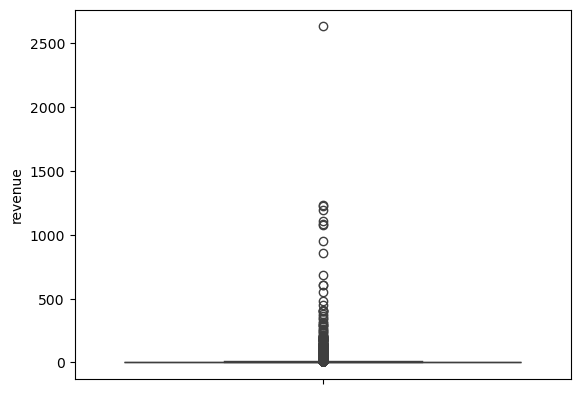

In [182]:
#Trazamos el diagrama de caja y bigotes.
sns.boxplot(orders_df['revenue'])

Bingo! como podemos ver, existe una gran cantidad de valores atípicos en las compras, estos valores representan compras de boletos de una gran cantidad de dinero, también es importante notar como la mayor parte de los datos esta ubicada casi en los valores mínimos, al ser estos la mayoría, la media esta más cerca de la mayor frecuencia de datos que de los valores atípicos.

#### LTV (Life Time Value)

In [183]:
#Ahora vamos a calcular el LTV